## Семинар 4: "Сверточные сети"

ФИО: __Господинов Георгий__

In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split
import torch
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

C:\Program Files\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Часть 1: Свертка

#### Одномерные сигналы
Начнем с одномерных сигналов — например, это могут быть различные временные ряды. 

<i>1.1 Реализуйте функцию, вычисляющую одномерную свертку.</i>

In [2]:
def t_convolve(signal, kernel):
    signal_convolved = np.zeros(len(signal)-len(kernel)+1)
    # 1. не забудьте перевернуть ядро!
    # 2. необходимо реализовать свертку без отступов, т.е. 
    #   размер результирующего сигнала должен быть меньше входного.
    for i in range(len(signal_convolved)):
        signal_convolved[i] = sum(signal[i:i+len(kernel)] * kernel[::-1])
    ##### YOUR CODE HERE #####
    return signal_convolved

Проверим правильность реализации, сравнив с реализацией из scipy

In [3]:
from scipy.signal import convolve

signal = np.random.rand(100)
kernel = np.random.rand(5)
t_result = t_convolve(signal, kernel)
b_result = convolve(signal, kernel, mode='valid')

np.testing.assert_allclose(t_result, b_result)

Посмотрим как операция свертки может помочь нам убрать шум из сигнала

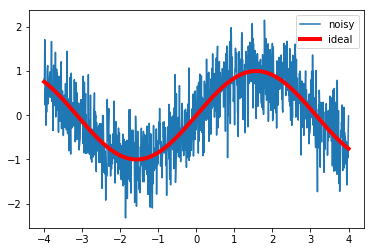

In [4]:
x = np.linspace(-4, 4, 1000)
signal = np.sin(x)
noisy_signal = signal + np.random.randn(signal.shape[0])*0.5
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.legend(loc=0)
plt.show()

Для подавления шума можно использовать усреднение значений сигнала в окрестности каждой точки (см. ЗБЧ). Вы можете убедиться, что такая операция может быть реализована при помощи свертки данных с ядром, $[\frac 1w, \frac 1w, ..., \frac 1w]$, где $w$ — размер окна.

<i>1.2  Вычислите свертку <b>зашумленного</b> сигнала с ядром $[0.2, 0.2, 0.2, 0.2, 0.2]$ </i>

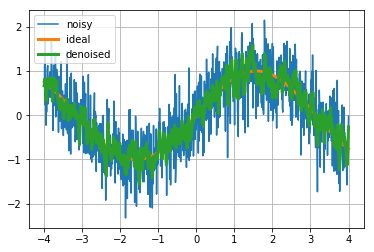

In [5]:
kernel_size = 5
kernel = np.ones(kernel_size) * 1/kernel_size
denoised_signal = convolve(noisy_signal, kernel, mode='same')
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, label='ideal', linewidth=3)
plt.plot(x, denoised_signal, label='denoised', linewidth=3)
plt.legend(loc=0)
plt.grid()

Заметим, что уровень шума значительно снизился! Попробуйте подобрать такую ширину окна, чтобы востановленный сигнал был наиболее похож на исходный.

<i> 1.3 Подберите размер окна <i>

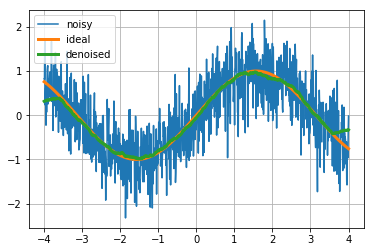

In [6]:
kernel_size = 100
kernel = np.ones(kernel_size) * 1/kernel_size
denoised_signal = convolve(noisy_signal, kernel, mode='same')
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, label='ideal', linewidth=3)
plt.plot(x, denoised_signal, label='denoised', linewidth=3)
plt.legend(loc=0)
plt.grid()

#### Многомерные сигналы
Перейдем теперь к черно-белым и цветным изображениям. Для ЧБ изображений имеем двумерный сигнал, для цветных — трехмерный (высота x ширина x каналы).

Для цветных изображений количество каналов ядра обычно совпадает с количеством каналов изображения. Таким образом, в результате получается черно-белое изображение.

<i>Для вычисления многомерных сверток используйте функцию convolve из from scipy.signal import convolve</i>

In [7]:
image = plt.imread('./it.jpg')

<i>1.4 Найдите в вашей любимой поисковой системе веса каналов для перевода цветного изображения в черно-белое. Постройте фильтр, который будет переводить цветное изображение в ЧБ</i>

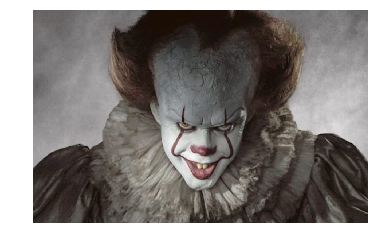

In [8]:
plt.imshow(image)
plt.axis('off')
plt.show()

In [9]:
color_to_bw = np.array([0.2983, 0.5870, 0.1140])

<i>1.5 На примере любого цветного изображения покажите результат его свертки с фильтром из предыдущего задания.</i>

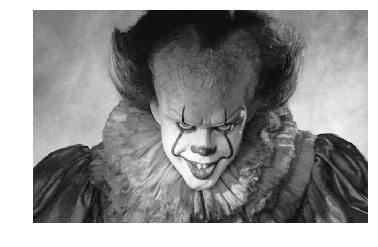

In [10]:
bw_image = convolve(image, color_to_bw.reshape(1,1,3)[:,:,::-1], mode='valid')[:,:,0]
# Не забудьте, что размер bw_image должен быть [w,h], а convolve вам вернет [w,h,1]
plt.imshow(bw_image, cmap=plt.cm.Greys_r)
plt.axis('off')
plt.show()

Операция свертки также позволяет находить границы на изображении. Для этого можно использовать, например, фильтр Собеля.

<i>1.6 Задайте ядро <a href="https://ru.wikipedia.org/wiki/Оператор_Собеля">фильтра Собеля</a> и продемонстрируйте результат его применения к любому цветному изображению.</i>

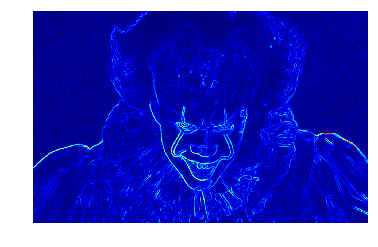

In [11]:
Gx = np.array([[-1, -2, -1],
               [0, 0, 0],
               [1, 2, 1]])

Gy = np.array([[-1, 0, 1],
               [-2, 0, 2],
               [-1, 0, 1]])

A1 = convolve(bw_image, Gx, mode='valid')
A2 = convolve(bw_image, Gy, mode='valid')

boundary = (A1**2 + A2**2) ** 0.5
plt.imshow(boundary, cmap='jet')#, cmap=plt.cm.Greys_r)
plt.axis('off')
plt.show()

В сверточных нейронных сетях каждый слой использует несколько фильтров. Допустим, у нас было изображение с тремя каналами (количество входных каналов). Рассмотрим банк из четырех фильтров (количество выходных каналов). Тогда изначально будет вычислена свертка с каждым фильтром — получим 4 ЧБ изображения. Теперь соединим их в одно, интерпретируя каждое ЧБ изображение как канал цветного: RGB$\alpha$.

<i>1.7 Реализуйте операцию свертки с банком фильтров (filter bank).</i>

In [12]:
def t_convolve_bank(signal, filter_bank):
    out = np.zeros(shape=(signal.shape[0], signal.shape[1], filter_bank.shape[0]))
    for idx,kernel in enumerate(filter_bank):
        out[:,:,idx] = convolve(signal, kernel.reshape(1,1,3)[:,:,::-1], mode='valid')[:,:,0]
    return out

<i>1.8 Задайте банк фильтров, меняющий порядок следования каналов с RGB на BGR.</i>

In [13]:
bank = np.array([[0, 0, 1],
                 [0, 1, 0],
                 [1, 0, 0]
                ])

<i>1.9 Продемонстрируйте результат свертки любого цветного изображения с банком фильтров из предыдущего пункта.</i>

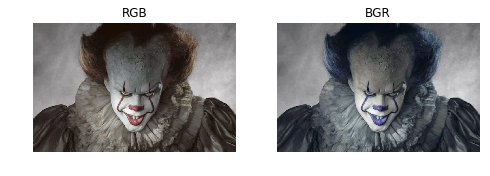

In [14]:
# Не забудьте, что после свертки вы скорее всего получите тензор типа float. 
# Чтобы imshow нормально отобразил результат, надо привести его к типу uint8 (нпр., при помощи .astype('uint8'))
plt.figure(figsize=(8,30))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('RGB')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(t_convolve_bank(image, bank).astype('uint8'))
plt.title('BGR')
plt.axis('off')
plt.show()

В процессе обучения сверточных нейронных сетей настраиваются веса элементов фильтр банка. Это позволяет не заниматься подбором коэффициентов "руками", а задавать лишь размер ядра: ширину, высоту, количество входных и выходных каналов. В итоге получаем четырехмерный массив (тензор).

### Часть 2: Пулинг

При использовании сверточных слоев принято использовать слои пулинга. Эта операция позволяет уменьшить пространственные размерности изображения и избавиться от избыточности.

<i>2.1 Реализуйте операции пулинга для цветных изображений</i>

In [15]:
def maxpool(image, w=2):
    assert(image.ndim == 3)
    m, n = image.shape[:2]
    M, N = image.shape[0]//w, image.shape[1]//w
    return image[:M*w, :N*w, :].reshape(M, w, N, w, image.shape[-1]).max(axis=(1,3))
    

def medianpool(image, w=2):
    assert(image.ndim == 3)
    m, n = image.shape[:2]
    M, N = image.shape[0]//w, image.shape[1]//w
    return np.median(image[:M*w, :N*w, :].reshape(M, w, N, w, image.shape[-1]), axis=(1,3))

Как и в первой части, посмотрим сначала как эта опреация влияет на цветные изображения.

<i>2.2 Взять цветное изображение и добавить к нему <a href="https://ru.wikipedia.org/wiki/Salt_and_pepper"> шум соль и перец</a>. Применить медианный пулинг и максимальный пулинг.</i>

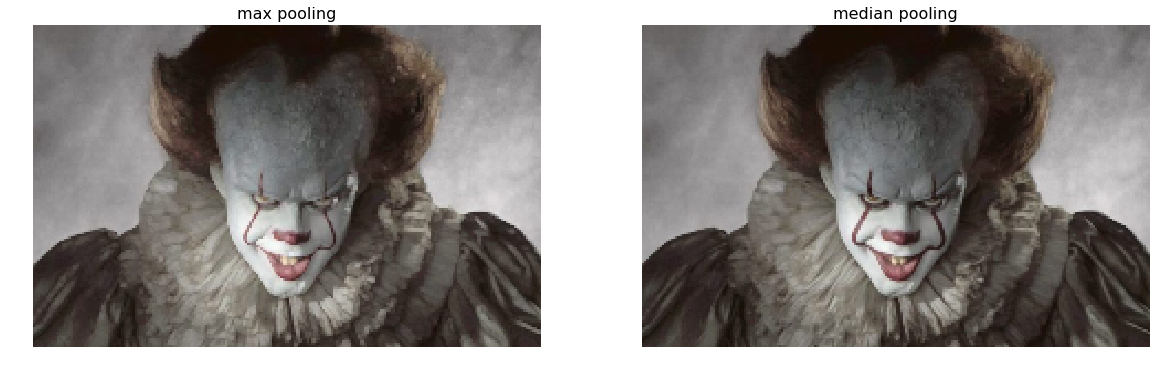

In [16]:
plt.figure(figsize=(20,20))
plt.subplot(1, 2, 1)
plt.imshow(maxpool(image, w=4))
plt.title('max pooling', fontsize=16)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(medianpool(image, w=4).astype('uint8'))
plt.title('median pooling', fontsize=16)
plt.axis('off')
plt.show()

Видно, что медиана дает лучший результат. Максимум сильно завышает белые тона, картинка портится. С другой стороны, это свойство максимума может помочь на наборе данных MNIST: яркие цифры останутся, а шум будет отброшен.

In [17]:
def salt_pepper_noise(image, density=0.01, s=0.5):
    out = image.copy()
    count = int(image.shape[0]*image.shape[1]*density)
    s_count = int(count*s)
    y = np.random.choice(image.shape[0], count)
    x = np.random.choice(image.shape[1], count)
    out[y[:s_count], x[:s_count], :] = np.array([255, 255, 255])
    out[y[s_count:], x[s_count:], :] = np.array([0, 0, 0])
    return out
    

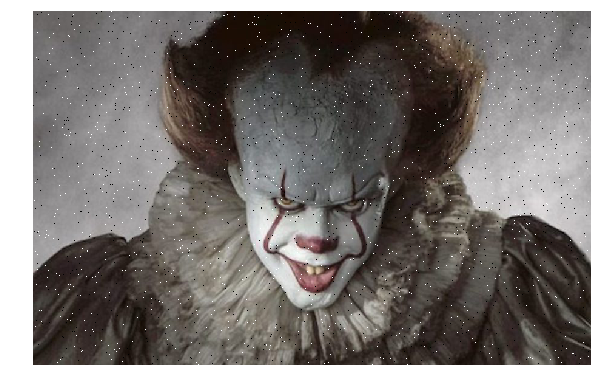

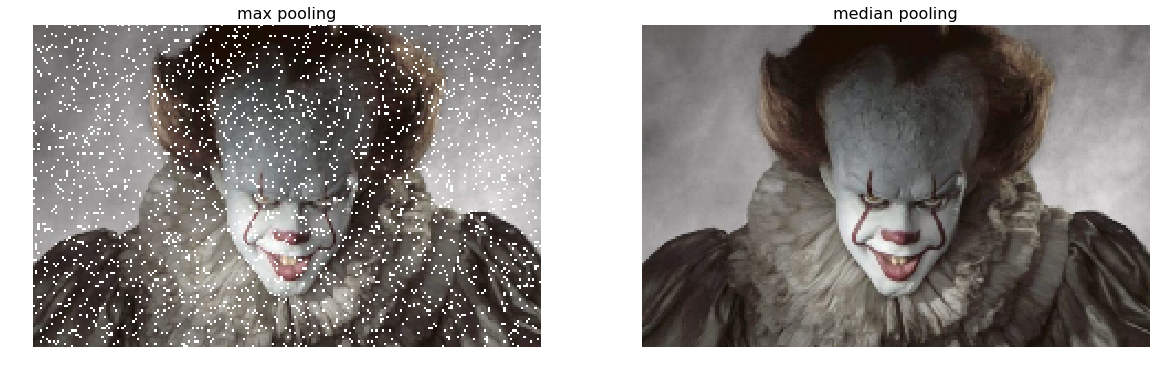

In [18]:
plt.figure(figsize=(10,10))
noised_image = salt_pepper_noise(image)
plt.imshow(noised_image)
plt.axis('off')
plt.show()

plt.figure(figsize=(20,20))
plt.subplot(1, 2, 1)
plt.imshow(maxpool(noised_image, w=4))
plt.title('max pooling', fontsize=16)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(medianpool(noised_image, w=4).astype('uint8'))
plt.title('median pooling', fontsize=16)
plt.axis('off')
plt.show()

<i>2.3 Какой тип пулинга лучше справился с поставленной задачей? Почему?</i>

Очевидно, максимум не устойчив к выбросам)) Если перец он фильтрует, то соль полностью оставляет. Медиана отлично справляется с задачей.

### Часть 3: Сверточная сеть на pyTorch

pyTorch предоставляет модули свертки и пулинга. Попробуем построить сеть и натренировать ее на данных MNIST. Для загрузки данных воспользуйтесь кодом со второго семинара.

Воспользуемся кодом с предыдущего семинара, чтобы обучить сверточную сеть на данных MNIST. Попробуем две архитектуры: 
2. input -> 8 Conv 3x3 -> ReLU -> maxpool -> 16 Conv 3x3 -> ReLU -> ravel -> Linear -> LogSoftmax
1. input -> 8 Conv 3x3 -> ReLU -> 16 Conv 3x3 -> ReLU -> maxpool -> 32 Conv 3x3 -> ravel -> Linear -> LogSoftmax

Здесь запись "c conv KxK" означает то, что на выходе должно получиться c каналов, а размер ядра — KxK

Ниже приведен пример сети. <i>(Документация: http://pytorch.org/docs/)</i>

In [19]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Processing...
Done!


In [20]:
# пример сверточной сети

image_size = 28
channels = 1
class ConvClassifier(nn.Module):
    def __init__(self, image_size):
        super(ConvClassifier, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(channels, 3, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2))
        self.linear_layers = nn.Sequential(nn.Linear(image_size//2*image_size//2*3, 10), nn.LogSoftmax())
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [30]:
def train(network, epochs, learning_rate):
    loss = nn.NLLLoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = Variable(X)
                y = Variable(y)
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.data[0])
                loss_batch.backward()
                optimizer.step()
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = Variable(X)
                y = Variable(y)
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.data[0])
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
    except KeyboardInterrupt:
        pass
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_epochs, label='Train')
    plt.plot(test_loss_epochs, label='Test')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy_epochs, label='Train accuracy')
    plt.plot(test_accuracy_epochs, label='Test accuracy')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.show()
    return test_accuracy_epochs

C:\Program Files\Anaconda3\lib\site-packages\torch\nn\modules\container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 19... (Train/Test) NLL: 0.148/0.143	Accuracy: 0.957/0.958

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


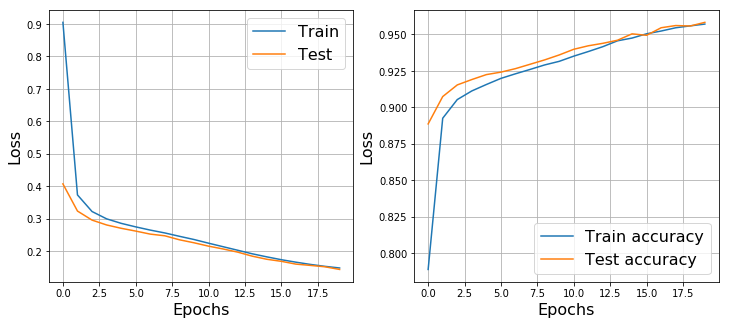

In [32]:
from IPython.display import clear_output
import sys
network = ConvClassifier(image_size=image_size)
net0_ac = train(network, 20, 1e-4)

<i>3.1 Обучите сверточные сети с архитектурами (1) и (2). Какое качество удалось получить на тестовой выборке? Какой результат получался на полносвязной нейронной сети?</i>

### input -> 8 Conv 3x3 -> ReLU -> maxpool -> 16 Conv 3x3 -> ReLU -> ravel -> Linear -> LogSoftmax

In [23]:
class model_1(nn.Module):
    def __init__(self, image_size):
        super(model_1, self).__init__()
        self.conv_layers = nn.Sequential(
                                            nn.Conv2d(channels, 8, 3, padding=1), 
                                            nn.ReLU(),
                                            nn.MaxPool2d(2),
                                            nn.Conv2d(8, 16, 3, padding=1), 
                                            nn.ReLU()
                                        )
        self.linr_layers = nn.Sequential(
                                            nn.Linear(image_size//2*image_size//2*16, 10),
                                            nn.LogSoftmax(dim=1)                                           
                                        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linr_layers(x) 
        return x

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 19... (Train/Test) NLL: 0.026/0.048	Accuracy: 0.992/0.986

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


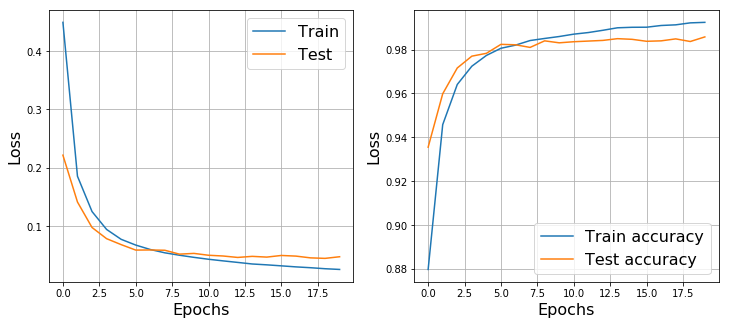

In [33]:
network = model_1(image_size=image_size)
net1_ac = train(network, 20, 1e-4)

### input -> 8 Conv 3x3 -> ReLU -> 16 Conv 3x3 -> ReLU -> maxpool -> 32 Conv 3x3 -> ravel -> Linear -> LogSoftmax

In [25]:
class model_2(nn.Module):
    def __init__(self, image_size):
        super(model_2, self).__init__()
        self.conv_layers = nn.Sequential(
                                            nn.Conv2d(channels, 8, 3, padding=1), 
                                            nn.ReLU(),
                                            nn.Conv2d(8, 16, 3, padding=1),
                                            nn.ReLU(),
                                            nn.MaxPool2d(2),
                                            nn.Conv2d(16, 32, 3, padding=1), 
                                        )
        self.linr_layers = nn.Sequential(
                                            nn.Linear(image_size//2*image_size//2*32, 10),
                                            nn.LogSoftmax(dim=1)                                           
                                        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linr_layers(x) 
        return x

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 19... (Train/Test) NLL: 0.022/0.044	Accuracy: 0.993/0.986

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


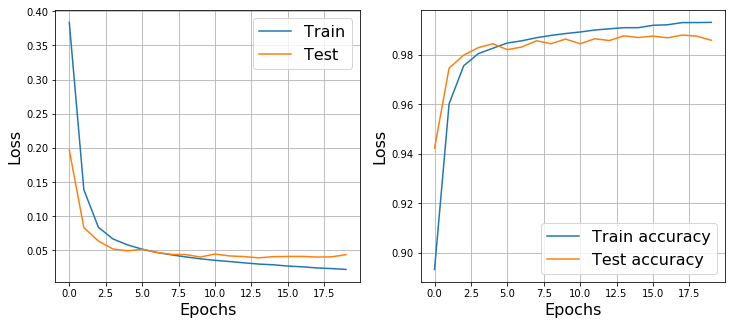

In [35]:
network = model_2(image_size=image_size)
net2_ac = train(network, 20, 1e-4)

<i>3.2 На каких объектах сеть ошибается сильнее всего? Нарисуйте эти объекты с правильными и предсказаными метками.</i>

In [58]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    y = y.numpy()
    prediction = network.forward(X).data.numpy()
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

real(predicted)


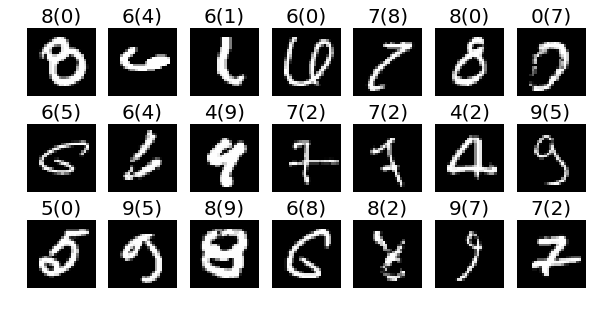

In [116]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')
print('real(predicted)')

<i>3.3 Поэкспериментируйте с различными архитектурами сверточных сетей. Смогли ли вы улучшить результат на тестовой выборке?</i>

## gospodinov network (Gnet):
### input -> 8 Conv 5x5 -> ReLU -> maxpool -> 16 Conv 5x5 -> ReLU -> maxpool -> 32 Conv 5x5 -> ravel -> Linear -> LogSoftmax

In [66]:
class Gnet(nn.Module):
    def __init__(self, image_size):
        super(Gnet, self).__init__()
        self.conv_layers = nn.Sequential(
                                            nn.Conv2d(channels, 8, 5, padding=2), 
                                            nn.ReLU(),
                                            nn.MaxPool2d(2),
                                            nn.Conv2d(8, 16, 5, padding=2),
                                            nn.ReLU(),
                                            nn.MaxPool2d(2),
                                            nn.Conv2d(16, 32, 5, padding=2), 
                                        )
        self.linr_layers = nn.Sequential(
                                            nn.Linear(image_size//4*image_size//4*32, 10),
                                            nn.LogSoftmax(dim=1)                                           
                                        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linr_layers(x) 
        return x

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 19... (Train/Test) NLL: 0.025/0.035	Accuracy: 0.992/0.988

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


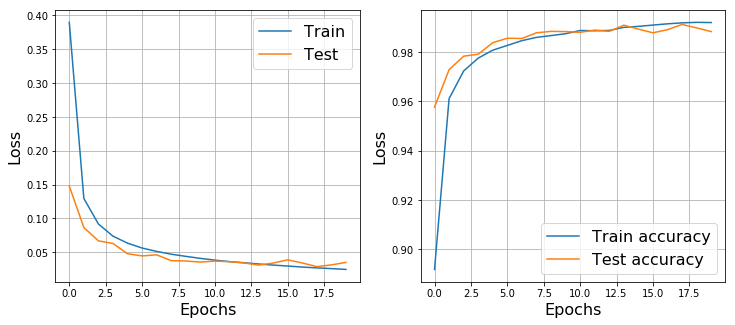

In [67]:
network = Gnet(image_size=image_size)
gnet_ac = train(network, 20, 1e-4)

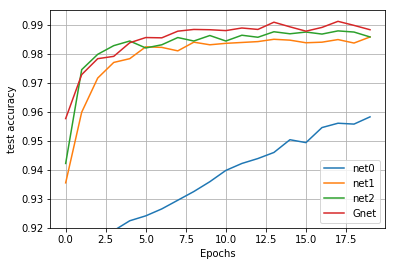

In [113]:
plt.plot(net0_ac, label='net0')
plt.plot(net1_ac, label='net1')
plt.plot(net2_ac, label='net2')
plt.plot(gnet_ac, label='Gnet')
plt.ylabel('test accuracy')
plt.xlabel('Epochs')
plt.ylim([0.92, 0.995])
plt.legend()
plt.grid()
plt.show()

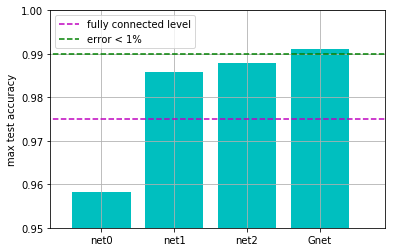

In [114]:
plt.plot([-1, 4], [0.975, 0.975], 'm--', label='fully connected level')
plt.plot([-1, 4], [0.99, 0.99], 'g--', label='error < 1%')
plt.bar(['net0', 'net1', 'net2', 'Gnet'],
       [np.max(net0_ac), np.max(net1_ac), np.max(net2_ac), np.max(gnet_ac)], color='c')
plt.ylim([0.95, 1])
plt.xlim([-0.7, 3.9])
plt.ylabel('max test accuracy')
plt.legend(loc='upper left')
plt.grid()
plt.show()

Сеть net0, которую разбирали на семинаре, полносвязные сети обходят, но введение дополнительных сверточных слоев(в сетях net1 и net2) позволяет значительно повысить точность. Добиться error rate < 1% позволило использование ядра свертки 5x5 в архитектуре net2. Для ускорения сходимости был добавлен еще один max pooling с шириной окна 2. (Сам по себе дополнительный max pooling в архитектуре net2 слегка снижал качество).

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: